This notebook demonstrates the pipeline for running site response simulations in batch. You can choose to run the simulations using multiple CPU processors.

In [22]:
from PySeismoSoil.class_ground_motion import Ground_Motion
from PySeismoSoil.class_Vs_profile import Vs_Profile
from PySeismoSoil.class_curves import Multiple_GGmax_Damping_Curves
from PySeismoSoil.class_parameters import HH_Param_Multi_Layer
from PySeismoSoil.class_simulation import (
    Linear_Simulation,
    Equiv_Linear_Simulation,
    Nonlinear_Simulation,
)
from PySeismoSoil.class_batch_simulation import Batch_Simulation

# 1. Linear simulations in batch

In [23]:
accel_in = Ground_Motion('../tests/files/sample_accel.txt', unit='gal')
profile_1 = Vs_Profile('../tests/files/profile_FKSH14.txt')
profile_2 = Vs_Profile('../tests/files/profile_P001.txt')

In [24]:
lin_sim_1 = Linear_Simulation(profile_1, accel_in, boundary='rigid')
lin_sim_2 = Linear_Simulation(profile_2, accel_in, boundary='elastic')

In [25]:
batch_lin_sim = Batch_Simulation([lin_sim_1, lin_sim_2])

Parallel computing in progress... 

done.


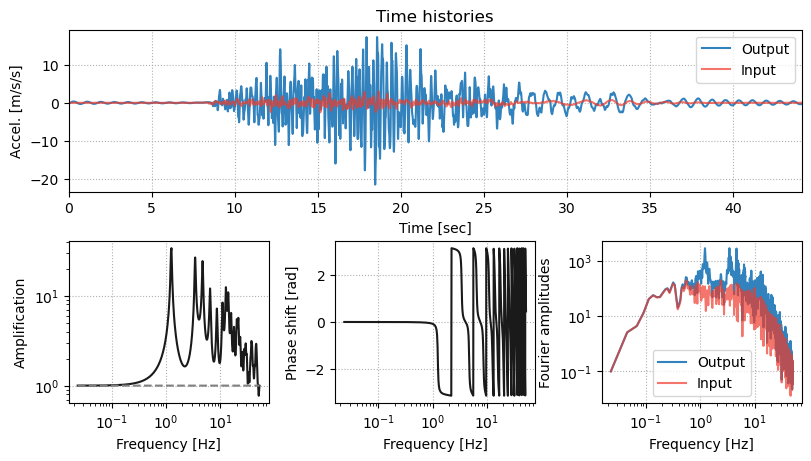

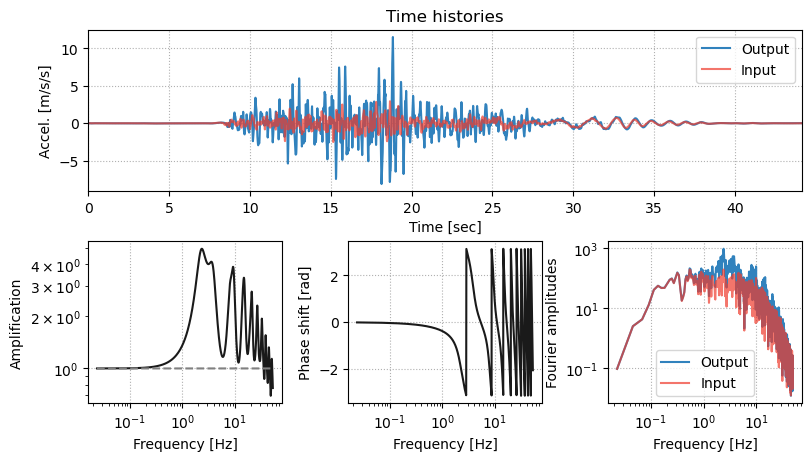

In [26]:
lin_results = batch_lin_sim.run(
    parallel=True, 
    n_cores=2, 
    verbose=True,
    options=dict(every_layer=False, show_fig=True, verbose=False)
)

In [27]:
lin_results

# 2. Equivalent linear simulations in batch

In [28]:
curves_1 = Multiple_GGmax_Damping_Curves(
    data='../tests/files/curve_FKSH14.txt'
)
curves_2 = Multiple_GGmax_Damping_Curves(data='../tests/files/curve_P001.txt')

(To see how to construct $G/G_{\max}$ and damping curves from $V_S$ profiles, go to [this notebook](./Pipeline_04_Equivalent_Linear_Method.ipynb).)

In [29]:
equiv_sim_1 = Equiv_Linear_Simulation(
    profile_1, accel_in, curves_1, boundary='elastic'
)
equiv_sim_2 = Equiv_Linear_Simulation(
    profile_2, accel_in, curves_2, boundary='elastic'
)

In [30]:
batch_equiv_sim = Batch_Simulation([equiv_sim_1, equiv_sim_2])

In [31]:
equiv_results = batch_equiv_sim.run(
    parallel=True, 
    n_cores=2, 
    verbose=True,
    options=dict(verbose=False, show_fig=False)
);

Parallel computing in progress... 

---------- Convergence achieved ---------------
---------- Convergence achieved ---------------
done.


In [32]:
equiv_results

# 3. Nonlinear simulations in batch

In [33]:
hh_g_param_1 = HH_Param_Multi_Layer('../tests/files/HH_G_FKSH14.txt')
hh_g_param_2 = HH_Param_Multi_Layer('../tests/files/HH_G_P001.txt')

In [34]:
hh_x_param_1 = HH_Param_Multi_Layer('../tests/files/HH_X_FKSH14.txt')
hh_x_param_2 = HH_Param_Multi_Layer('../tests/files/HH_X_P001.txt')

(To see how to construct HH parameters for $G/G_{\max}$ and damping behaviors, go to [this notebook](./Pipeline_05_Nonlinear_Method.ipynb).)

In [35]:
nonl_sim_1 = Nonlinear_Simulation(
    profile_1,
    accel_in,
    G_param=hh_g_param_1,
    xi_param=hh_x_param_1,
    boundary='elastic',
)
nonl_sim_2 = Nonlinear_Simulation(
    profile_2,
    accel_in,
    G_param=hh_g_param_2,
    xi_param=hh_x_param_2,
    boundary='rigid',
)

In [36]:
batch_nonl_sim = Batch_Simulation([nonl_sim_1, nonl_sim_2])

In [37]:
nonl_results = batch_nonl_sim.run(
    parallel=True,
    n_cores=2,
    verbose=True,
    options=dict(remove_sim_dir=True, verbose=False, show_fig=False),
)

Parallel computing in progress... 

In [17]:
nonl_results

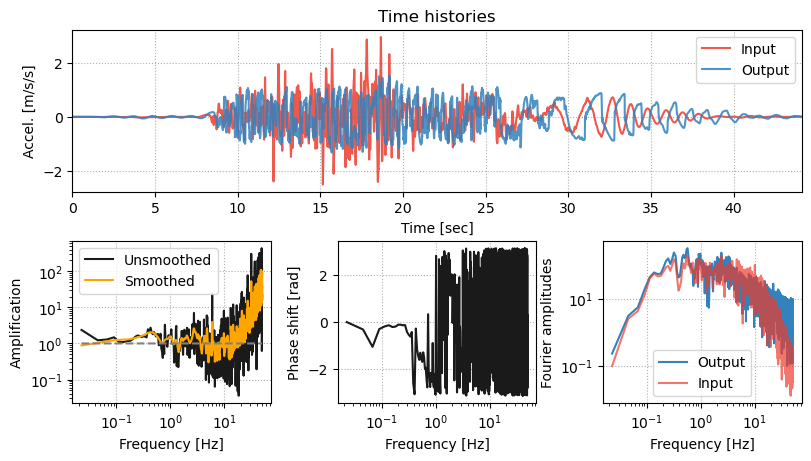

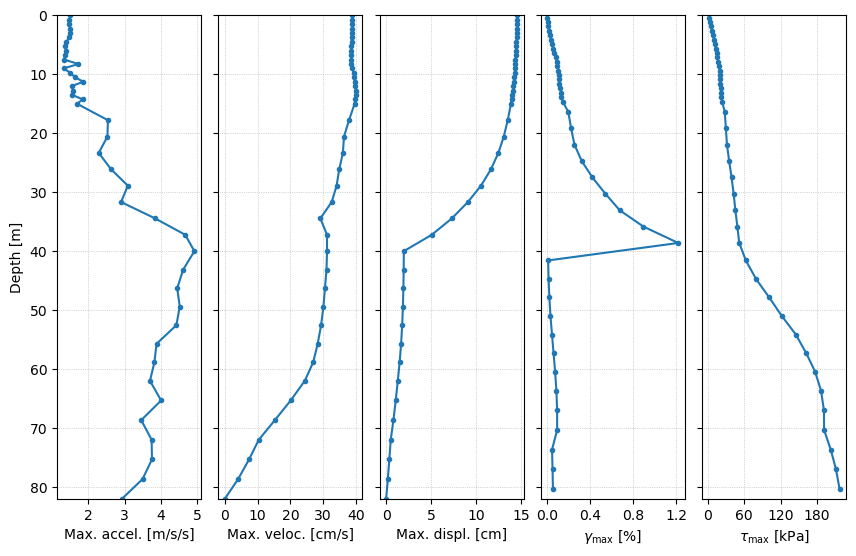

In [18]:
nonl_results[1].plot();

# 4. Using the forkserver context

By default on unix systems (i.e. HPC systems), the `multiprocessing` module uses the `fork` context to spawn subprocesses. What this means is that each subprocess created by the module is an exact copy of the main process, including all imports and existing variables at the time of subprocess creation.

For code where the sole purpose is to run PySeismoSoil simulations, the `fork` method of creating subprocesses is sufficient. However, for situations where PySeismoSoil may only be a portion of a larger code that is being executed, this can result in major slow downs in batch processing. This is because each subprocess has to create a copy of a potentially large volume of additional modules, variables, etc. from the main process.

The `use_ctx=True` command changes the subprocess creation method used by batch PySeismoSoil from `fork` to `forkserver`. The `forkserver` context creates a trimmed down Python server such that only the necessary PySeismoSoil modules are loaded, and any subprocesses simply fork from this minimal server instead of the potentially large main process.

The ideal use case for the python `multiprocessing` module with the `forkserver` context has the subprocesses spawn from the top-level code with a `__name__ == '__main__'` gate to protect the code entry. Therefore, to use the `forkserver` context, the top-level code needs to be put in a `__name__ == '__main__'` gate.

**This option is recommended for running batch PySeismoSoil simulations on a HPC system, when the code imports involve more than just PySeismoSoil.**

### The `use_ctx` option is illustrated below with the linear simulation example.

In [19]:
accel_in = Ground_Motion('../tests/files/sample_accel.txt', unit='gal')
profile_1 = Vs_Profile('../tests/files/profile_FKSH14.txt')
profile_2 = Vs_Profile('../tests/files/profile_P001.txt')

lin_sim_1 = Linear_Simulation(profile_1, accel_in, boundary='rigid')
lin_sim_2 = Linear_Simulation(profile_2, accel_in, boundary='elastic')

We add the `use_ctx=True` option to the initialization of the `Batch_Simulation` object (default is False).

In [20]:
batch_lin_sim = Batch_Simulation([lin_sim_1, lin_sim_2], use_ctx=True)

If `verbose=True`, the output will specify that the forkserver context is being used. Note the addition of the mandatory if statement for `__name__`.

Parallel computing in progress using forkserver... 

done.


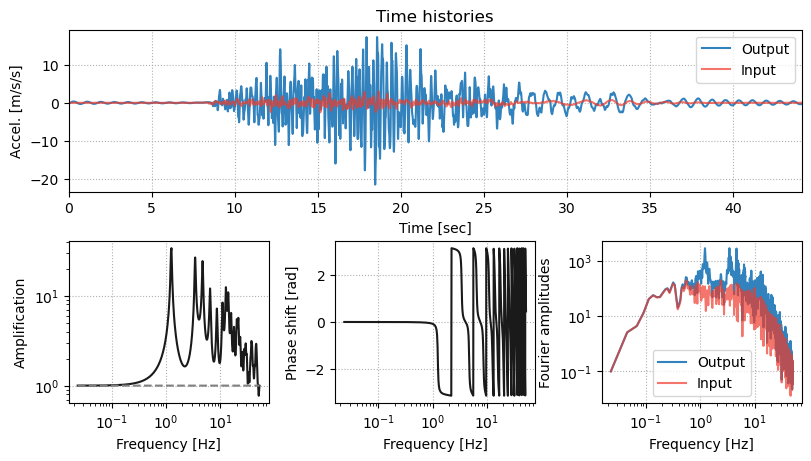

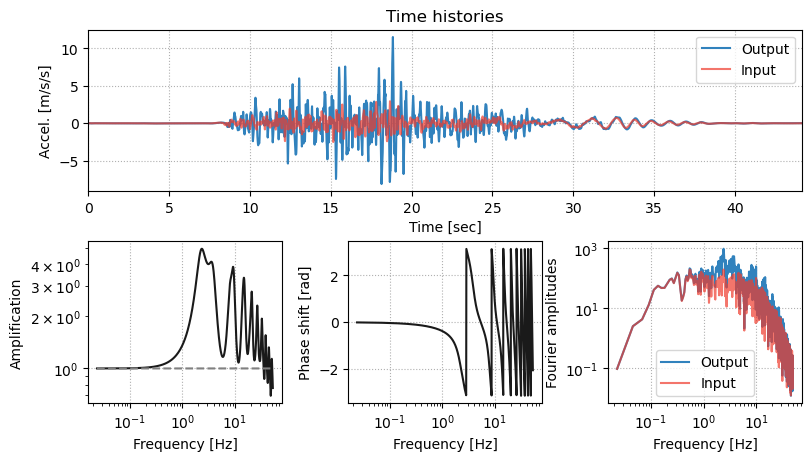

In [21]:
if __name__ == '__main__':
  lin_results = batch_lin_sim.run(
      parallel=True, 
      n_cores=2, 
      verbose=True,
      options=dict(every_layer=False, show_fig=True, verbose=False)
  )

In a top level .py file, the entire code may look something like the following.
```python
from PySeismoSoil.class_ground_motion import Ground_Motion
from PySeismoSoil.class_Vs_profile import Vs_Profile
from PySeismoSoil.class_simulation import Linear_Simulation
from PySeismoSoil.class_batch_simulation import Batch_Simulation

if __name__ == '__main__':
  accel_in = Ground_Motion('../tests/files/sample_accel.txt', unit='gal')
  profile_1 = Vs_Profile('../tests/files/profile_FKSH14.txt')
  profile_2 = Vs_Profile('../tests/files/profile_P001.txt')

  lin_sim_1 = Linear_Simulation(profile_1, accel_in, boundary='rigid')
  lin_sim_2 = Linear_Simulation(profile_2, accel_in, boundary='elastic')

  batch_lin_sim = Batch_Simulation([lin_sim_1, lin_sim_2], use_ctx=True)

  lin_results = batch_lin_sim.run(
    parallel=True, 
    n_cores=2, 
    verbose=True,
    options=dict(every_layer=False, show_fig=True, verbose=False)
  )
```